## Imports and Setup

In [254]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.linear_model import LinearRegression

# plt.style.use('light_background')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 16,
    'axes.labelpad': 20,      # Distance between axis labels and plot
    'axes.titlepad': 24       # Distance between title and plot
})

captions_path = "../captions/gpt41_captions.json"
common_sense_path = "../commonsense.json"
dataset_path = "../transformed_dataset.json"

## Helper Functions & Load Metadata

In [255]:
def is_correct(uid, answer):
    """Check correctness based on UID and answer"""
    return (uid.endswith("B") and answer == "negative") or (uid.endswith("A") and answer == "positive")

def display_left_aligned(df):
    display(
        df.style
        .set_table_styles([{'selector': 'th, td', 'props': [('text-align', 'left')]}])
    )

def display_left_aligned_no_index(df):
    display(
        df.style
        .hide(axis='index')
        .set_table_styles([{'selector': 'th, td', 'props': [('text-align', 'left')]}])
    )

def load_common_sense_mapping():
    """Load common sense category mapping"""
    try:
        with open(common_sense_path, "r") as f:
            common_sense_data = json.load(f)
        mapping = {}
        for item in common_sense_data:
            mapping[item["commonSense"]] = item["conceptCategory"]
        print(f"Loaded common sense mapping for {len(mapping)} categories")
        return common_sense_data, mapping
    except FileNotFoundError:
        print(f"{common_sense_path} not found")
        return {}, {}
    except Exception as e:
        print(f"Error loading common_sense.json: {e}")
        return {}, {}

def load_metadata():
    """Load metadata from qwen25_captions.json"""
    metadata = {}
    try:
        with open(captions_path, "r") as f:
            qwen_data = json.load(f)
        for item in qwen_data:
            uid = item["uid"] # Keep the full UID (e.g., "0008")
            metadata[uid] = {
                'concept': item.get('concept', ''),
                'caption': item.get('caption', ''),
                'commonSense': item.get('commonSense', '0'),
            }
        print(f"Loaded metadata for {len(metadata)} UIDs from {captions_path}")
    except FileNotFoundError:
        print(f"{captions_path} not found")
    except Exception as e:
        print(f"Error loading qwen25_captions.json: {e}")
    return metadata

def load_dataset():
    """Load the complete test datset"""
    dataset = {}
    try:
        with open(dataset_path, "r") as f:
            raw_dataset = json.load(f)
        for item in raw_dataset:
            uid = item["uid"] # Keep the ID ("0008_A")
            dataset[uid] = {
                'concept': item.get('concept', ''),
                'caption': item.get('caption', ''),
                'commonSense': item.get('commonSense', '0'),
            }
        print(f"Loaded metadata for {len(dataset)} UIDs from {dataset_path}")
    except FileNotFoundError:
        print(f"{dataset_path} not found")
    except Exception as e:
        print(f"Error loading {dataset_path}: {e}")
    return dataset

## Load and process data

In [256]:
folder_path = "../results"
result_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]
metadata = load_metadata()
commonsense_data, common_sense_mapping = load_common_sense_mapping()

# Initialize data structures
model_performance = {}
uid_analysis = defaultdict(dict)
common_sense_analysis = defaultdict(lambda: defaultdict(list))
difficulty_by_common_sense = defaultdict(list)
answer_distribution = defaultdict(Counter)
pos_neg_analysis = defaultdict(lambda: {'A_correct': 0, 'A_total': 0, 'B_correct': 0, 'B_total': 0})

# Process each model's results
for file_name in result_files:
    model_name = file_name.replace(".json", "")
    with open(os.path.join(folder_path, file_name), "r") as f:
        records = json.load(f)
    correct_count = 0
    total_count = len(records)
    for record in records:
        uid = record["uid"]
        answer = record["answer"]
        is_correct_answer = is_correct(uid, answer)
        base_uid = uid.replace("_A", "").replace("_B", "")
        variant = "A" if uid.endswith("A") else "B"
        
        if is_correct_answer:
            correct_count += 1
        uid_analysis[uid][model_name] = is_correct_answer
        answer_distribution[model_name][answer] += 1
        
        if variant == "A":
            pos_neg_analysis[model_name]['A_total'] += 1
            if is_correct_answer:
                pos_neg_analysis[model_name]['A_correct'] += 1
        else:
            pos_neg_analysis[model_name]['B_total'] += 1
            if is_correct_answer:
                pos_neg_analysis[model_name]['B_correct'] += 1

        if base_uid in metadata:
            common_sense_id = int(metadata[base_uid].get('commonSense', 0))
            common_sense_category = common_sense_mapping.get(common_sense_id, f"Unknown_{common_sense_id}")
            common_sense_analysis[common_sense_category][model_name].append(is_correct_answer)
            difficulty_by_common_sense[common_sense_category].append(is_correct_answer)

    model_performance[model_name] = {
        'accuracy': correct_count / total_count,
        'correct': correct_count,
        'total': total_count
    }
print("Data processing complete!")

Loaded metadata for 200 UIDs from ../captions/gpt41_captions.json
Loaded common sense mapping for 10 categories
Data processing complete!
Data processing complete!


In [257]:
commonsense_df = pd.DataFrame(commonsense_data)
commonsense_df = commonsense_df[['commonSense', 'conceptCategory', 'example']]
display_left_aligned_no_index(commonsense_df)

commonSense,conceptCategory,example
0,Anything else*,Animals are running.
1,HOI,A person playing the guitar.
2,Taste / Nutrition / Food,A plate of high-calorie food.
3,Color / Material / Shape,A wooden floor in the living room.
4,Functionality / Status / Affordance,An animal capable of flying in the tree.
5,And / Or / Not,A man without beard.
6,Factual Knowledge,A building in US capital.
7,Meta Class,Felidae animals.
8,Relationship,A bench near trees.
9,Unusual Observations,Refraction of light on a glass cup.


## Commonsense Distribution Summary

In [258]:
commonsense_df = pd.DataFrame(commonsense_data)
commonsense_df = commonsense_df[['commonSense', 'conceptCategory', 'example']]
display_left_aligned_no_index(commonsense_df)

commonsense_counter = Counter()
with open(dataset_path, "r") as f:
    raw_dataset = json.load(f)
    for item in raw_dataset:
        commonsense = item.get("commonSense", "unknown")
        commonsense_counter[commonsense] += 1

total = sum(commonsense_counter.values())
commonsense_dist_df = pd.DataFrame([
    {"commonsense": level,
     "category": common_sense_mapping[int(level)],
     "Count": count,
     "Percentage (%)": round((count / total) * 100, 2)}
    for level, count in sorted(commonsense_counter.items())
])
print("=== Commonsense Distribution ===")
display_left_aligned_no_index(commonsense_dist_df)

commonSense,conceptCategory,example
0,Anything else*,Animals are running.
1,HOI,A person playing the guitar.
2,Taste / Nutrition / Food,A plate of high-calorie food.
3,Color / Material / Shape,A wooden floor in the living room.
4,Functionality / Status / Affordance,An animal capable of flying in the tree.
5,And / Or / Not,A man without beard.
6,Factual Knowledge,A building in US capital.
7,Meta Class,Felidae animals.
8,Relationship,A bench near trees.
9,Unusual Observations,Refraction of light on a glass cup.


=== Commonsense Distribution ===


commonsense,category,Count,Percentage (%)
0,Anything else*,290,72.500000
1,HOI,12,3.000000
2,Taste / Nutrition / Food,8,2.000000
3,Color / Material / Shape,28,7.000000
4,Functionality / Status / Affordance,10,2.500000
5,And / Or / Not,8,2.000000
6,Factual Knowledge,12,3.000000
7,Meta Class,8,2.000000
8,Relationship,8,2.000000
9,Unusual Observations,16,4.000000


## Model Performances

In [259]:
print("=== MODEL PERFORMANCE & POSITIVE vs NEGATIVE ANALYSIS ===")
df_performance = pd.DataFrame(model_performance).T
df_performance = df_performance.sort_values('accuracy', ascending=False)

pos_neg_df = pd.DataFrame(pos_neg_analysis).T
pos_neg_df['A_accuracy'] = pos_neg_df['A_correct'] / pos_neg_df['A_total']
pos_neg_df['B_accuracy'] = pos_neg_df['B_correct'] / pos_neg_df['B_total']
pos_neg_df['pos_neg_diff'] = pos_neg_df['A_accuracy'] - pos_neg_df['B_accuracy']

combined_df = pd.DataFrame({
    'Total_Records': df_performance['total'],
    'Correct_Predictions': df_performance['correct'],
    'Overall_Accuracy': (df_performance['correct'] / df_performance['total']),
    'A_Accuracy': pos_neg_df['A_accuracy'],
    'B_Accuracy': pos_neg_df['B_accuracy'],
    'A_vs_B_Diff': pos_neg_df['pos_neg_diff']
})

combined_df = combined_df.sort_values('Overall_Accuracy', ascending=False)
display_df = combined_df.copy()
display_df['Overall_Accuracy'] = (display_df['Overall_Accuracy'] * 100).round(1)
display_df['A_Accuracy'] = (display_df['A_Accuracy'] * 100).round(1)
display_df['B_Accuracy'] = (display_df['B_Accuracy'] * 100).round(1)
display_df['A_vs_B_Diff'] = (display_df['A_vs_B_Diff'] * 100).round(1)
display_df.columns = ['Total Records', 'Correct', 'Accuracy (%)', 'A Accuracy (%)', 'B Accuracy (%)', 'A-B Diff (%)']

print(f"Total number of model configs: {len(display_df)}")
print("\nModel Performance & A vs B Analysis:")
display(display_df)

=== MODEL PERFORMANCE & POSITIVE vs NEGATIVE ANALYSIS ===
Total number of model configs: 37

Model Performance & A vs B Analysis:


,Total Records,Correct,Accuracy (%),A Accuracy (%),B Accuracy (%),A-B Diff (%)
cvr_gpt5,400.0,319.0,79.8,88.5,71.0,17.5
cvr_gpt41,400.0,299.0,74.8,85.5,64.0,21.5
cmr_gpt5_gpt5,400.0,299.0,74.8,79.0,70.5,8.5
cvr_gemini20,400.0,298.0,74.5,90.0,59.0,31.0
cvr_gemini25,400.0,296.0,74.0,90.0,58.0,32.0
sdr_gpt41_gpt41,400.0,293.0,73.2,81.0,65.5,15.5
cmr_gpt41_gptoss,400.0,293.0,73.2,77.5,69.0,8.5
cmr_gpt41_qwen3,400.0,289.0,72.2,73.0,71.5,1.5
cmr_gemini20_gemini20,400.0,288.0,72.0,82.0,62.0,20.0
cvr_qwen25,400.0,288.0,72.0,84.5,59.5,25.0


## UID-Based Worst Performance Analysis

In [260]:
print("\n=== UID-BASED WORST PERFORMANCE ANALYSIS ===")
uid_performance = {}
for uid, model_results in uid_analysis.items():
    if model_results:
        correct_count = sum(model_results.values())
        total_count = len(model_results)
        success_rate = correct_count / total_count
        uid_performance[uid] = {
            'success_rate': success_rate,
            'correct_count': correct_count,
            'total_models': total_count,
            'failed_models': total_count - correct_count
        }

sorted_uids = sorted(uid_performance.items(), key=lambda x: x[1]['success_rate'])
print("=== TOP 25 MOST DIFFICULT UIDS ===")
print(f"{'UID':<12} {'Success Rate':<13} {'Failed/Total':<12} {'Concept':<25} {'Type':<8}")
print("-" * 70)
for i, (uid, stats) in enumerate(sorted_uids[:50]):
    base_uid = uid.replace("_A", "").replace("_B", "")
    variant = "A (pos)" if uid.endswith("A") else "B (neg)"
    concept = metadata.get(base_uid, {}).get('concept', 'unknown')[:24]
    print(f"{uid:<12} {stats['success_rate']:<13.1%} {stats['failed_models']}/{stats['total_models']:<11} {concept:<25} {variant:<8}")


=== UID-BASED WORST PERFORMANCE ANALYSIS ===
=== TOP 25 MOST DIFFICULT UIDS ===
UID          Success Rate  Failed/Total Concept                   Type    
----------------------------------------------------------------------
0640_B       0.0%          37/37          person holding fish rive  B (neg) 
0739_A       0.0%          37/37          bunch flowers yellow sta  A (pos) 
0713_B       0.0%          37/37          firefighters saving fore  B (neg) 
0159_B       0.0%          37/37          old wooden house country  B (neg) 
0789_B       0.0%          37/37          palm tree leaves          B (neg) 
0094_B       0.0%          37/37          tennis racket or court    B (neg) 
0753_B       2.7%          36/37          animals running           B (neg) 
0025_A       2.7%          36/37          steel beams building      A (pos) 
0386_B       2.7%          36/37          gift box pink ribbon      B (neg) 
0829_A       2.7%          36/37          oven kitchen              A (pos) 
002

## Commonsense Based Performance

In [261]:
print("\n=== COMMONSENSE CATEGORY PERFORMANCE ===")
common_sense_performance = {}
for category, model_results in common_sense_analysis.items():
    common_sense_performance[category] = {}
    for model, results in model_results.items():
        if results:
            common_sense_performance[category][model] = sum(results) / len(results)
            
common_sense_df = pd.DataFrame(common_sense_performance).T.fillna(0)
if not common_sense_df.empty:
    common_sense_df['avg_accuracy'] = common_sense_df.mean(axis=1)
    common_sense_df = common_sense_df.sort_values('avg_accuracy')
    print("Common Sense Category difficulty (lowest accuracy first):")
    display_left_aligned(common_sense_df.round(3))


=== COMMONSENSE CATEGORY PERFORMANCE ===
Common Sense Category difficulty (lowest accuracy first):


,cmr_gemma3_llama4,sdr_gpt41_deepseekr1,cvr_gpt41,cmr_gpt41_qwen3,cmr_gemma3_gemma3,sdr_gpt41_gpt41,cmr_gemma3_qwen3,cmr_qwen25_deepseekr1,cmr_qwen25_qwen3,sdr_gpt41_gptoss,cmr_llama4_qwen3,cmr_gemini20_gemini20,cmr_gpt41_gpt41,cmr_gpt41_llama4,cmr_gpt41_gemma3,cvr_gemini20,cmr_qwen25_llama4,cmr_llama4_deepseekr1,cvr_qwen25,cmr_qwen25_gemma3,sdr_gpt41_qwen3,sdr_gemini20_gemini20,cvr_gpt5,cmr_gpt41_deepseekr1,cmr_gemma3_deepseekr1,cmr_llava16_deepseekr1,cvr_gemma3,cmr_gpt41_gptoss,cmr_llava16_qwen3,cmr_llama4_gemma3,cvr_mistral3,cmr_llava16_llama4,sdr_gpt41_llama4,cmr_llava16_gemma3,cvr_gemini25,cmr_gpt5_gpt5,cmr_llama4_llama4,avg_accuracy
Color / Material / Shape,0.500000,0.607000,0.714000,0.571000,0.429000,0.536000,0.464000,0.607000,0.536000,0.679000,0.464000,0.607000,0.607000,0.429000,0.500000,0.679000,0.464000,0.464000,0.536000,0.429000,0.429000,0.500000,0.750000,0.607000,0.571000,0.393000,0.536000,0.607000,0.429000,0.536000,0.357000,0.286000,0.429000,0.250000,0.679000,0.607000,0.464000,0.520000
And / Or / Not,0.625000,0.500000,0.625000,0.625000,0.375000,0.750000,0.500000,0.375000,0.500000,0.375000,0.750000,0.500000,0.750000,0.500000,0.250000,0.625000,0.625000,0.625000,0.625000,0.250000,0.625000,0.625000,0.750000,0.500000,0.625000,0.625000,0.625000,0.750000,0.375000,0.500000,0.625000,0.500000,0.500000,0.375000,0.500000,0.625000,0.875000,0.561000
Unusual Observations,0.750000,0.500000,0.688000,0.500000,0.625000,0.562000,0.625000,0.688000,0.562000,0.312000,0.625000,0.625000,0.625000,0.562000,0.562000,0.750000,0.688000,0.625000,0.625000,0.562000,0.500000,0.500000,0.750000,0.562000,0.562000,0.375000,0.625000,0.438000,0.438000,0.500000,0.500000,0.375000,0.562000,0.375000,0.562000,0.562000,0.562000,0.562000
Functionality / Status / Affordance,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.800000,0.500000,0.600000,0.600000,0.500000,0.700000,0.600000,0.600000,0.600000,0.600000,0.700000,0.700000,0.500000,0.600000,0.800000,0.700000,0.700000,0.700000,0.600000,0.500000,0.700000,0.500000,0.500000,0.500000,0.600000,0.800000,0.700000,0.700000,0.800000,0.500000,0.643000
Taste / Nutrition / Food,0.625000,0.375000,0.625000,0.875000,0.625000,0.625000,0.625000,0.875000,0.750000,0.750000,0.375000,0.875000,0.750000,0.750000,0.625000,0.625000,0.625000,0.750000,0.625000,0.625000,0.500000,0.625000,0.625000,0.625000,0.875000,0.750000,0.750000,0.875000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.750000,0.625000,0.875000,0.676000
Anything else*,0.672000,0.645000,0.748000,0.745000,0.659000,0.759000,0.745000,0.697000,0.714000,0.728000,0.741000,0.734000,0.721000,0.714000,0.693000,0.752000,0.714000,0.700000,0.741000,0.672000,0.628000,0.655000,0.807000,0.721000,0.707000,0.662000,0.672000,0.762000,0.669000,0.645000,0.662000,0.679000,0.552000,0.641000,0.755000,0.769000,0.672000,0.701000
Relationship,0.750000,0.875000,0.750000,0.625000,0.875000,0.625000,0.875000,0.750000,0.750000,0.625000,0.750000,0.750000,0.750000,0.750000,0.625000,0.750000,0.625000,0.875000,0.750000,0.750000,0.500000,0.750000,0.750000,0.500000,0.875000,0.625000,0.750000,0.750000,0.500000,0.750000,0.625000,0.625000,0.500000,0.500000,0.750000,0.750000,0.750000,0.706000
Factual Knowledge,0.667000,0.667000,0.750000,0.667000,0.750000,0.833000,0.833000,0.750000,0.833000,0.583000,0.750000,0.750000,0.750000,0.750000,0.750000,0.833000,0.833000,0.750000,0.667000,0.750000,0.583000,0.667000,0.750000,0.750000,0.917000,0.750000,0.917000,0.583000,0.583000,0.583000,0.500000,0.667000,0.250000,0.667000,0.833000,0.667000,0.750000,0.712000
Meta Class,0.625000,0.625000,0.875000,0.875000,0.625000,0.750000,0.750000,0.625000,0.500000,0.625000,0.750000,0.875000,0.625000,0.625000,0.750000,0.875000,0.625000,0.750000,0.750000,0.625000,0.750000,0.625000,0.875000,0.750000,0.625000,0.750000,0.875000,0.750000,0.875000,0.750000,0.750000,0.750000,0.375000,0.625000,0.875000,0.750000,0.875000,0.723000
HOI,0.750000,0.833000,1.000000,0.833000,0.750000,0.833000,0.750000,0.833000,0.833000,0.750000,0.

## Common Sense Difficulty Analysis

In [262]:
print("\n=== COMMON SENSE DIFFICULTY ANALYSIS ===")
common_sense_difficulty = {}
for category, results in difficulty_by_common_sense.items():
    if results:
        success_rate = sum(results) / len(results)
        common_sense_difficulty[category] = {
            'success_rate': success_rate,
            'total_attempts': len(results),
            'difficulty_score': 1 - success_rate
        }

df = pd.DataFrame.from_dict(common_sense_difficulty, orient='index')
df = df.sort_values('success_rate')
df['success_rate_pct'] = (df['success_rate'] * 100).round(2)
print("Most difficult common sense categories:")
display_left_aligned(df[['success_rate_pct', 'total_attempts', 'difficulty_score']].rename(columns={
    'success_rate_pct': 'Success Rate (%)',
    'total_attempts': 'Total Attempts',
    'difficulty_score': 'Difficulty Score'
}))


=== COMMON SENSE DIFFICULTY ANALYSIS ===
Most difficult common sense categories:


,Success Rate (%),Total Attempts,Difficulty Score
Color / Material / Shape,52.030000,1036,0.479730
And / Or / Not,56.080000,296,0.439189
Unusual Observations,56.250000,592,0.437500
Functionality / Status / Affordance,64.320000,370,0.356757
Taste / Nutrition / Food,67.570000,296,0.324324
Anything else*,70.140000,10730,0.298602
Relationship,70.610000,296,0.293919
Factual Knowledge,71.170000,444,0.288288
Meta Class,72.300000,296,0.277027
HOI,78.830000,444,0.211712


## Model Performance Visualization

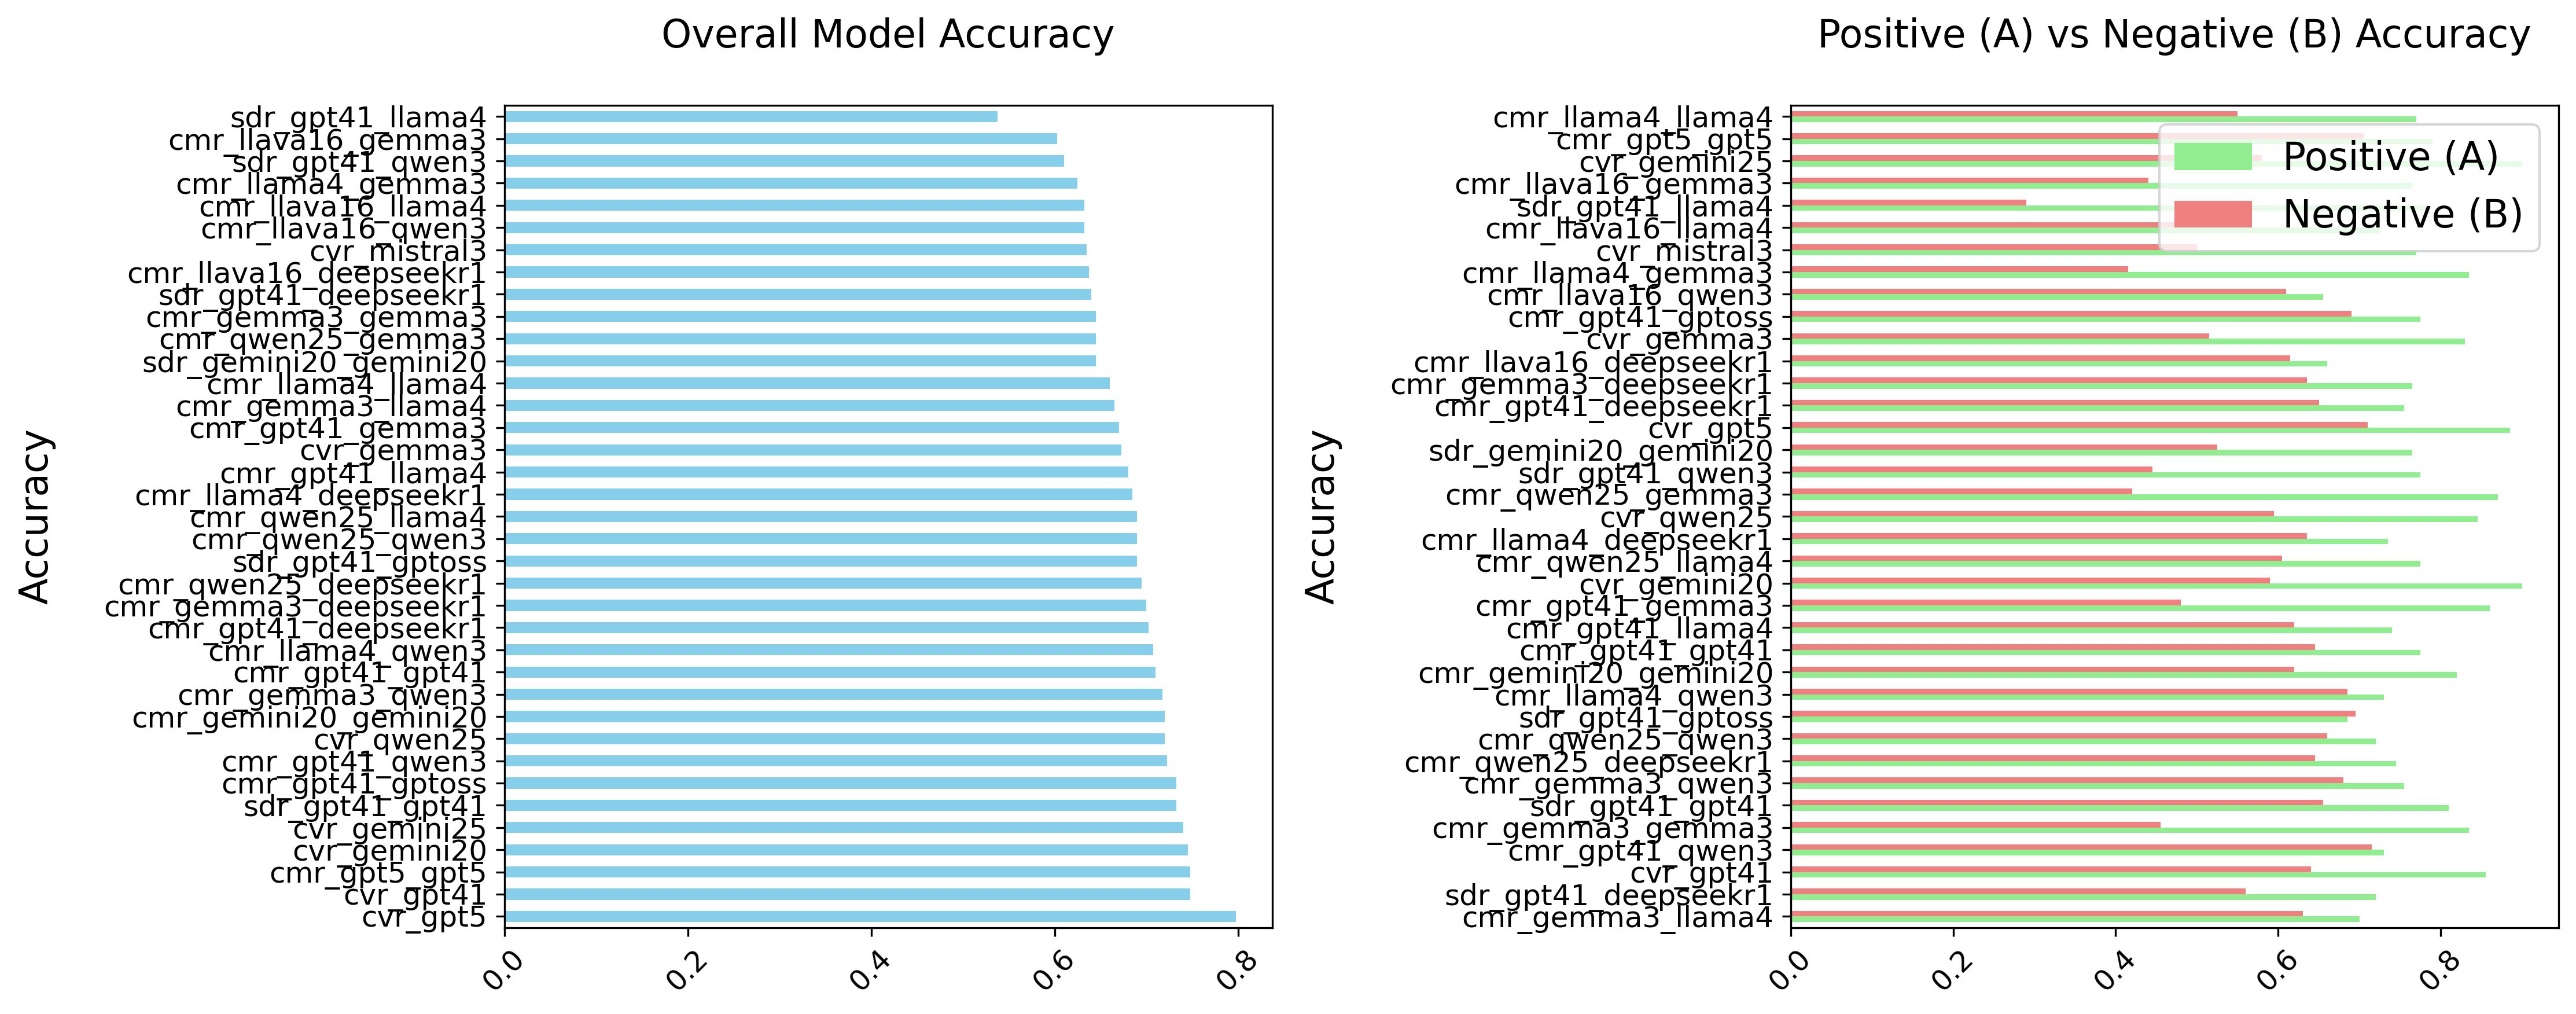

In [263]:
# Model Performance with A/B Breakdown
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Overall accuracy
df_performance['accuracy'].plot(kind='barh', ax=ax1, color='skyblue')
ax1.set_title('Overall Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)

# A vs B accuracy
pos_neg_plot_data = pos_neg_df[['A_accuracy', 'B_accuracy']]
pos_neg_plot_data.plot(kind='barh', ax=ax2, color=['lightgreen', 'lightcoral'])
ax2.set_title('Positive (A) vs Negative (B) Accuracy')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(['Positive (A)', 'Negative (B)'])

plt.tight_layout()
plt.show()

# Paradigm-Based Performance Summary

In [264]:
paradigm_groups = {'CVR': [], 'CMR': [], 'SDR': []}
for model_name in pos_neg_analysis.keys():
    if model_name.startswith('cvr_'):
        paradigm_groups['CVR'].append(model_name)
    elif model_name.startswith('cmr_'):
        paradigm_groups['CMR'].append(model_name)
    elif model_name.startswith('sdr'):
        paradigm_groups['SDR'].append(model_name)

paradigm_summary = {}
for paradigm, models in paradigm_groups.items():
    if models:
        total_a_correct = sum(pos_neg_analysis[model]['A_correct'] for model in models)
        total_a_attempts = sum(pos_neg_analysis[model]['A_total'] for model in models)
        total_b_correct = sum(pos_neg_analysis[model]['B_correct'] for model in models)
        total_b_attempts = sum(pos_neg_analysis[model]['B_total'] for model in models)
        avg_pos_acc = total_a_correct / total_a_attempts
        avg_neg_acc = total_b_correct / total_b_attempts
        avg_bias = avg_pos_acc - avg_neg_acc
        paradigm_summary[paradigm] = {
            'Avg Pos Acc (%)': round(avg_pos_acc * 100, 1),
            'Avg Neg Acc (%)': round(avg_neg_acc * 100, 1),
            'Avg Bias (%)': round(avg_bias * 100, 1),
            'Model Count': len(models)
        }

# Paradigm Summary

In [265]:
all_models = [model for models in paradigm_groups.values() for model in models]
total_a_correct_all = sum(pos_neg_analysis[model]['A_correct'] for model in all_models)
total_a_attempts_all = sum(pos_neg_analysis[model]['A_total'] for model in all_models)
total_b_correct_all = sum(pos_neg_analysis[model]['B_correct'] for model in all_models)
total_b_attempts_all = sum(pos_neg_analysis[model]['B_total'] for model in all_models)
overall_avg_pos = total_a_correct_all / total_a_attempts_all
overall_avg_neg = total_b_correct_all / total_b_attempts_all
overall_avg_bias = overall_avg_pos - overall_avg_neg
paradigm_summary['Overall'] = {
    'Avg Pos Acc (%)': round(overall_avg_pos * 100, 1),
    'Avg Neg Acc (%)': round(overall_avg_neg * 100, 1),
    'Avg Bias (%)': round(overall_avg_bias * 100, 1),
    'Model Count': len(all_models)
}

paradigm_df = pd.DataFrame.from_dict(paradigm_summary, orient='index')
paradigm_df = paradigm_df[['Avg Pos Acc (%)', 'Avg Neg Acc (%)', 'Avg Bias (%)']]
print("Paradigm Performance Summary:")
print(f"\n{'Paradigm':<12} {'Avg Pos Acc (%)':<16} {'Avg Neg Acc (%)':<16} {'Avg Bias (%)':<12}")
print("-" * 60)
for paradigm, data in paradigm_summary.items():
    print(f"{paradigm:<12} {data['Avg Pos Acc (%)']:<16} {data['Avg Neg Acc (%)']:<16} {data['Avg Bias (%)']:<12}")

Paradigm Performance Summary:

Paradigm     Avg Pos Acc (%)  Avg Neg Acc (%)  Avg Bias (%)
------------------------------------------------------------
CVR          85.5             59.0             26.5        
CMR          76.2             59.8             16.4        
SDR          75.7             52.8             22.8        
Overall      77.9             58.5             19.4        


## Bias Analysis Visualization

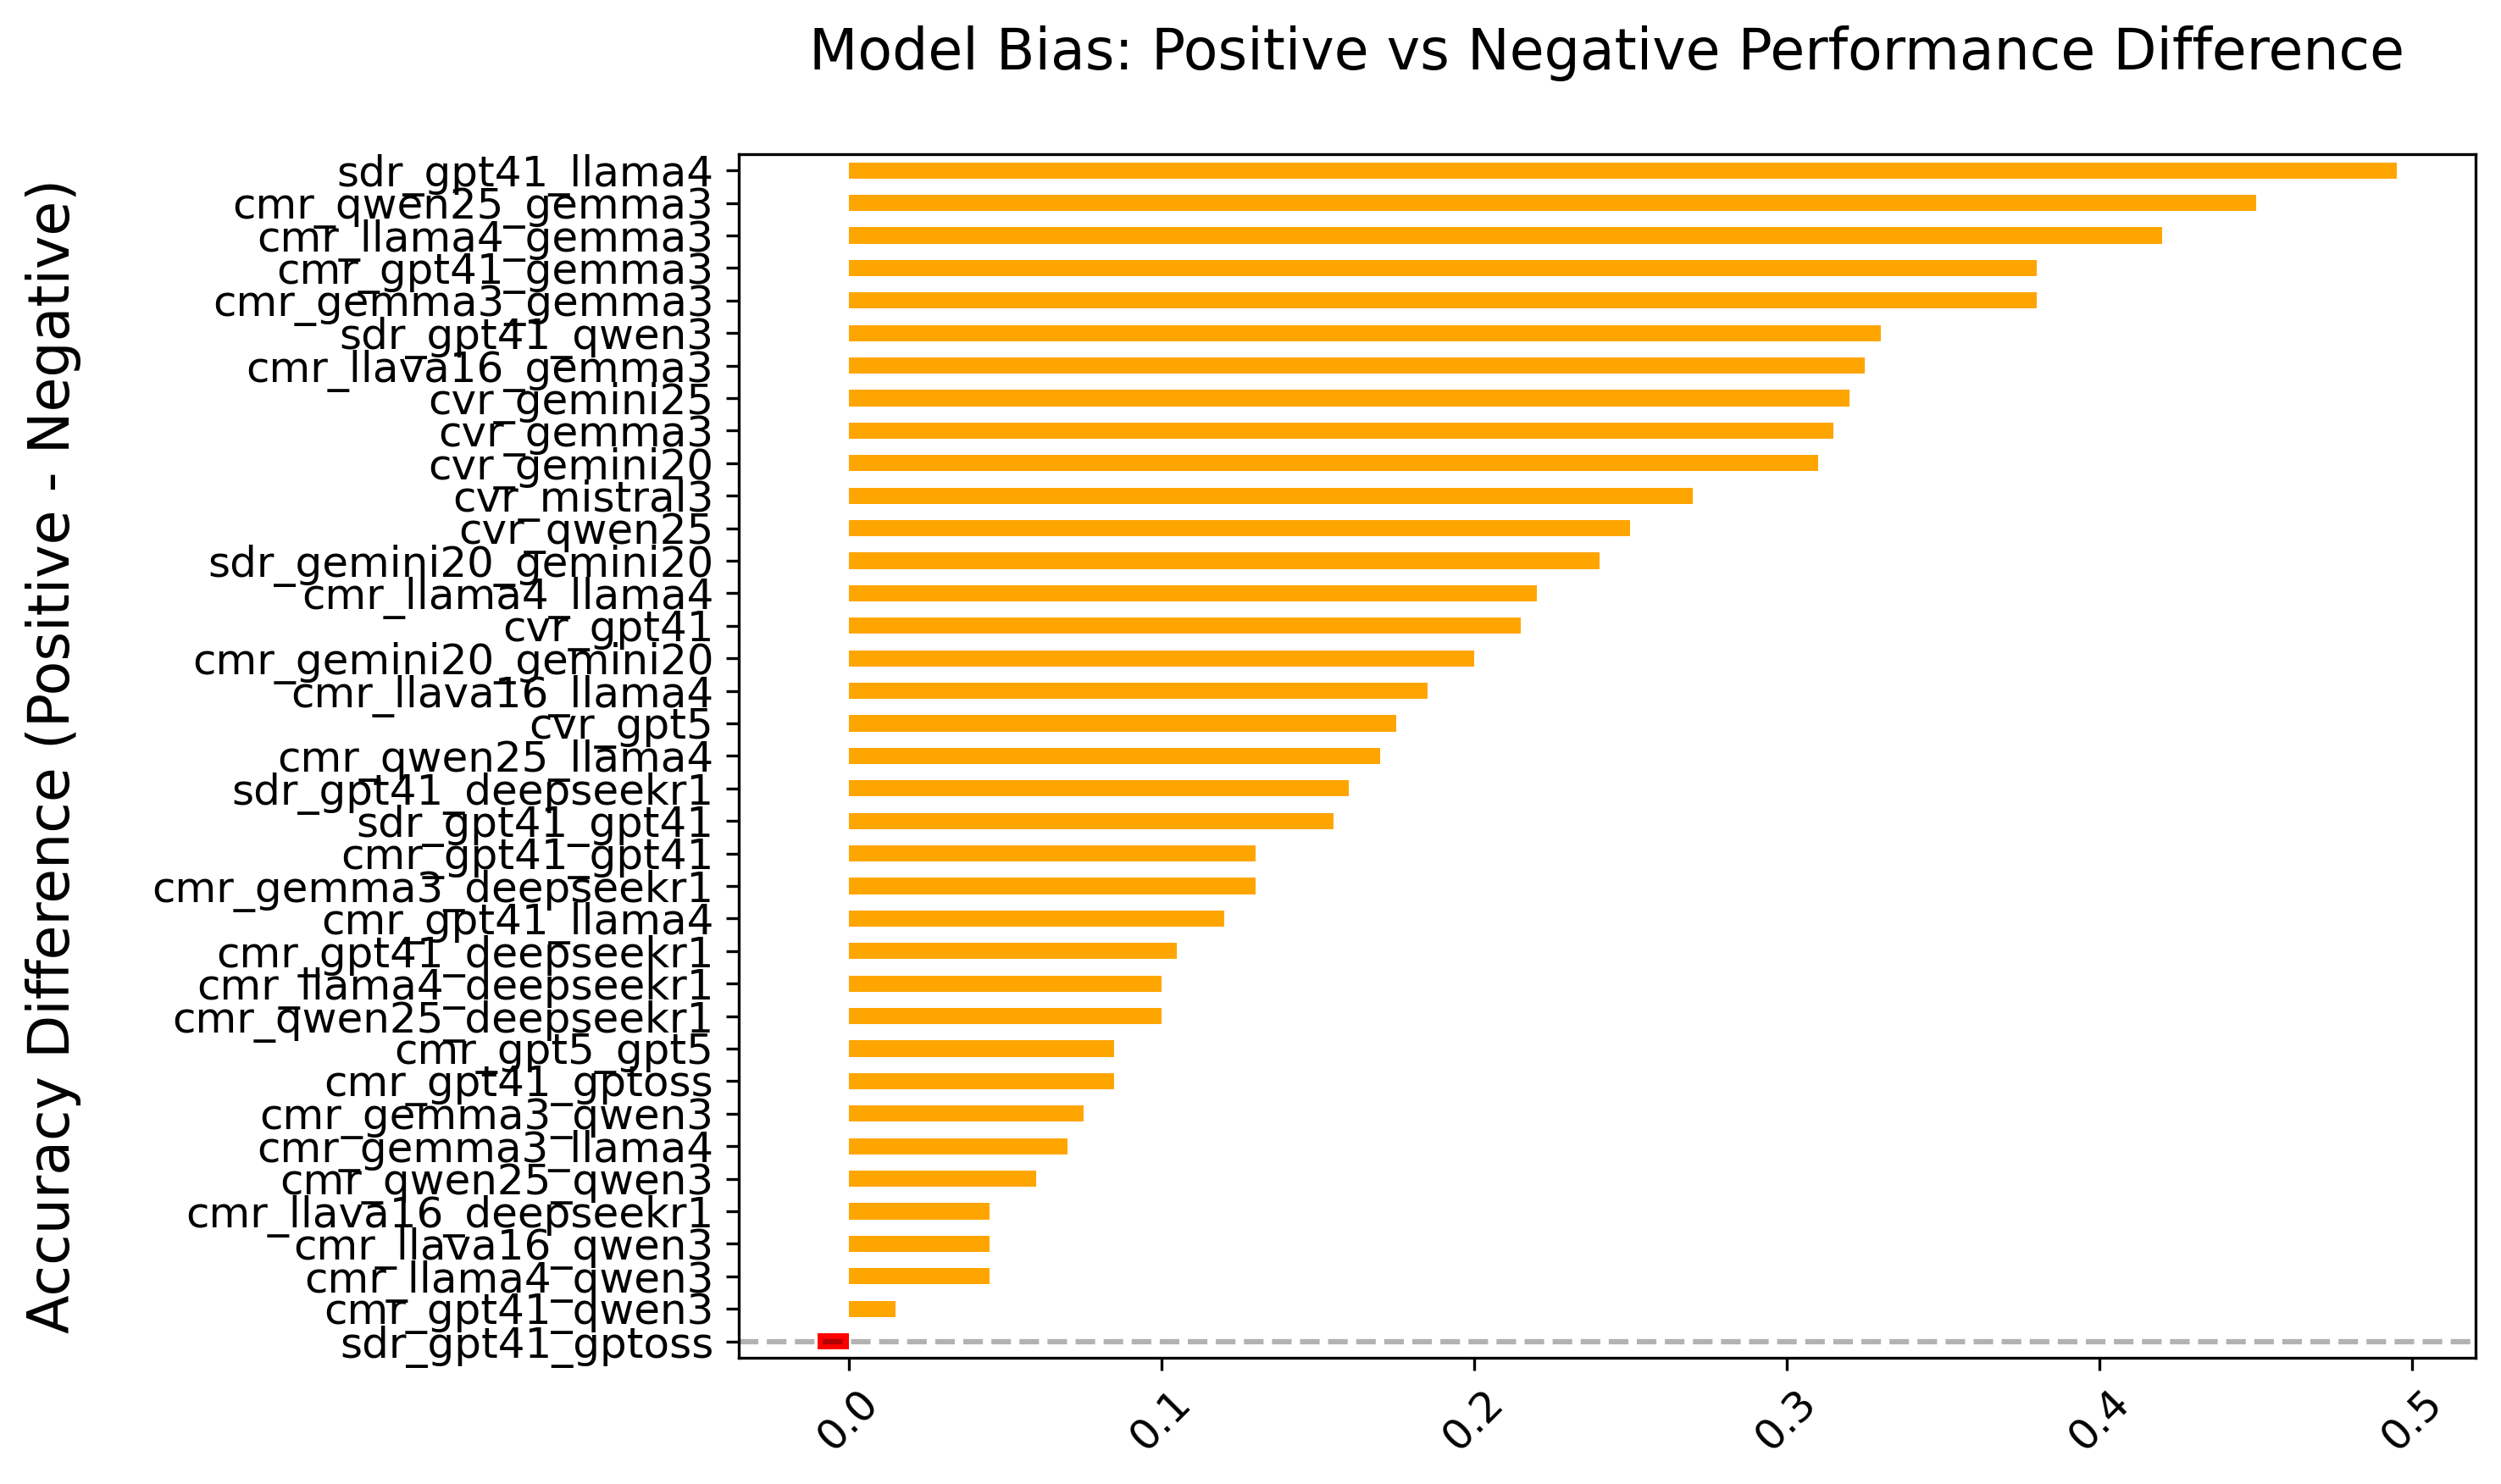

In [266]:
# Bias Analysis Visualization
if not pos_neg_df.empty:
    sorted_df = pos_neg_df.sort_values('pos_neg_diff')
    plt.figure(figsize=(10, 6))
    colors = ['red' if x < 0 else 'orange' for x in sorted_df['pos_neg_diff']]
    sorted_df['pos_neg_diff'].plot(kind='barh', color=colors)
    plt.title('Model Bias: Positive vs Negative Performance Difference')
    plt.ylabel('Accuracy Difference (Positive - Negative)')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Consistency Analysis (Inter-Model Agreement)

In [267]:
print("\n=== CONSISTENCY ANALYSIS ===")
print("\n1. Inter-Model Agreement Analysis")

def calculate_pairwise_agreement(model1_results, model2_results):
    """Calculate agreement percentage between two models"""
    common_uids = set(model1_results.keys()) & set(model2_results.keys())
    if not common_uids:
        return 0.0
    agreements = 0
    for uid in common_uids:
        if model1_results[uid] == model2_results[uid]:
            agreements += 1
    return agreements / len(common_uids)

model_results = {}
for uid, results in uid_analysis.items():
    for model, result in results.items():
        if model not in model_results:
            model_results[model] = {}
        model_results[model][uid] = result

models = list(model_results.keys())
agreement_matrix = pd.DataFrame(index=models, columns=models)
for i, model1 in enumerate(models):
    for j, model2 in enumerate(models):
        if i == j:
            agreement_matrix.loc[model1, model2] = 1.0
        else:
            agreement = calculate_pairwise_agreement(model_results[model1], model_results[model2])
            agreement_matrix.loc[model1, model2] = agreement

agreement_matrix = agreement_matrix.astype(float)
avg_agreement = {}
for model in models:
    others_agreement = [agreement_matrix.loc[model, other] for other in models if other != model]
    avg_agreement[model] = np.mean(others_agreement)

sorted_agreement = sorted(avg_agreement.items(), key=lambda x: x[1], reverse=True)
print("Models sorted by consistency (average agreement with other models):")
print(f"{'Model':<30} {'Avg Agreement':<15} {'Performance Rank'}")
print("-" * 65)
for model, agreement in sorted_agreement:
    perf_rank = list(combined_df.index).index(model) + 1 if model in combined_df.index else "N/A"
    print(f"{model:<30} {agreement:<15.3f} {perf_rank}")
print(f"\nOverall average inter-model agreement: {np.mean(list(avg_agreement.values())):.3f}")

upper_triangle = agreement_matrix.where(np.triu(np.ones(agreement_matrix.shape, dtype=bool), k=1))
flat_agreements = upper_triangle.stack().dropna()
print(f"\nHighest agreement pairs:")
top_pairs = flat_agreements.nlargest(5)
for (model1, model2), agreement in top_pairs.items():
    print(f"{model1} vs {model2}: {agreement:.3f}")
print(f"\nLowest agreement pairs:")
bottom_pairs = flat_agreements.nsmallest(5)
for (model1, model2), agreement in bottom_pairs.items():
    print(f"{model1} vs {model2}: {agreement:.3f}")


=== CONSISTENCY ANALYSIS ===

1. Inter-Model Agreement Analysis
Models sorted by consistency (average agreement with other models):
Model                          Avg Agreement   Performance Rank
-----------------------------------------------------------------
cvr_qwen25                     0.780           10
cmr_gpt41_gpt41                0.778           12
cmr_gpt41_deepseekr1           0.771           14
cvr_gemini20                   0.766           4
cvr_gpt41                      0.766           2
cmr_gpt41_gemma3               0.761           23
cmr_gpt41_llama4               0.759           21
cmr_qwen25_llama4              0.758           17
cmr_gemma3_gemma3              0.758           28
sdr_gpt41_gpt41                0.756           6
cvr_gpt5                       0.756           1
cmr_gemma3_qwen3               0.755           11
cmr_qwen25_deepseekr1          0.754           16
cmr_gpt5_gpt5                  0.753           3
cmr_gpt41_gptoss               0.752      

# Performance Variance Analysis

In [268]:
print("\n\n2. Performance Variance Analysis")
paradigm_performances = {'CVR': [], 'CMR': [], 'SDR': []}
for model_name, perf in model_performance.items():
    if model_name.startswith('cvr_'):
        paradigm_performances['CVR'].append(perf['accuracy'])
    elif model_name.startswith('cmr_'):
        paradigm_performances['CMR'].append(perf['accuracy'])
    elif model_name.startswith('sdr_'):
        paradigm_performances['SDR'].append(perf['accuracy'])

print("Performance variance by paradigm:")
print(f"{'Paradigm':<10} {'Count':<8} {'Mean':<8} {'Std Dev':<10} {'Min':<8} {'Max':<8} {'Range':<8}")
print("-" * 70)
paradigm_stats = {}
for paradigm, performances in paradigm_performances.items():
    if performances:
        mean_perf, std_perf = np.mean(performances), np.std(performances)
        min_perf, max_perf = np.min(performances), np.max(performances)
        range_perf = max_perf - min_perf
        paradigm_stats[paradigm] = {'mean': mean_perf, 'std': std_perf, 'min': min_perf, 'max': max_perf, 'range': range_perf, 'count': len(performances)}
        print(f"{paradigm:<10} {len(performances):<8} {mean_perf:<8.3f} {std_perf:<10.3f} {min_perf:<8.3f} {max_perf:<8.3f} {range_perf:<8.3f}")

print("\n\nPerformance variance within similar model configurations:")
cmr_by_captioner = defaultdict(list)
cmr_by_reasoner = defaultdict(list)
for model_name, perf in model_performance.items():
    if model_name.startswith('cmr_'):
        parts = model_name.split('_')
        if len(parts) >= 3:
            captioner, reasoner = parts[1], parts[2]
            cmr_by_captioner[captioner].append((reasoner, perf['accuracy']))
            cmr_by_reasoner[reasoner].append((captioner, perf['accuracy']))

print("\nVariance by captioning model (CMR paradigm):")
print(f"{'Captioner':<12} {'Count':<8} {'Mean':<8} {'Std Dev':<10} {'Range':<8}")
print("-" * 50)
for captioner, configs in cmr_by_captioner.items():
    if len(configs) > 1:
        accuracies = [acc for _, acc in configs]
        mean_acc, std_acc = np.mean(accuracies), np.std(accuracies)
        range_acc = np.max(accuracies) - np.min(accuracies)
        print(f"{captioner:<12} {len(configs):<8} {mean_acc:<8.3f} {std_acc:<10.3f} {range_acc:<8.3f}")

print("\nVariance by reasoning model (CMR paradigm):")
print(f"{'Reasoner':<12} {'Count':<8} {'Mean':<8} {'Std Dev':<10} {'Range':<8}")
print("-" * 50)
for reasoner, configs in cmr_by_reasoner.items():
    if len(configs) > 1:
        accuracies = [acc for _, acc in configs]
        mean_acc, std_acc = np.mean(accuracies), np.std(accuracies)
        range_acc = np.max(accuracies) - np.min(accuracies)
        print(f"{reasoner:<12} {len(configs):<8} {mean_acc:<8.3f} {std_acc:<10.3f} {range_acc:<8.3f}")



2. Performance Variance Analysis
Performance variance by paradigm:
Paradigm   Count    Mean     Std Dev    Min      Max      Range   
----------------------------------------------------------------------
CVR        7        0.723    0.050      0.635    0.797    0.162   
CMR        24       0.680    0.037      0.603    0.748    0.145   
SDR        6        0.642    0.061      0.537    0.733    0.195   


Performance variance within similar model configurations:

Variance by captioning model (CMR paradigm):
Captioner    Count    Mean     Std Dev    Range   
--------------------------------------------------
gemma3       4        0.682    0.028      0.073   
gpt41        6        0.703    0.022      0.062   
qwen25       4        0.680    0.020      0.050   
llama4       4        0.669    0.031      0.083   
llava16      4        0.626    0.014      0.035   

Variance by reasoning model (CMR paradigm):
Reasoner     Count    Mean     Std Dev    Range   
---------------------------------

# Consistency and Variation Analysis

In [269]:
print(f"\n\nCoefficient of Variation (CV = std/mean) by paradigm:")
print(f"{'Paradigm':<10} {'CV':<10} {'Consistency Rating'}")
print("-" * 35)
cv_thresholds = [(0.05, 'Very High'), (0.1, 'High'), (0.15, 'Moderate'), (0.2, 'Low'), (float('inf'), 'Very Low')]
for paradigm, stats in paradigm_stats.items():
    cv = stats['std'] / stats['mean'] if stats['mean'] != 0 else 0
    consistency = next(rating for threshold, rating in cv_thresholds if cv <= threshold)
    print(f"{paradigm:<10} {cv:<10.3f} {consistency}")

print(f"\n\nMost consistent model groups (lowest standard deviation):")
all_groups = []
for captioner, configs in cmr_by_captioner.items():
    if len(configs) > 2:
        accuracies = [acc for _, acc in configs]
        std_acc = np.std(accuracies)
        all_groups.append((f"CMR-{captioner}", std_acc, len(configs)))
for reasoner, configs in cmr_by_reasoner.items():
    if len(configs) > 2:
        accuracies = [acc for _, acc in configs]
        std_acc = np.std(accuracies)
        all_groups.append((f"CMR-{reasoner}", std_acc, len(configs)))

all_groups.sort(key=lambda x: x[1])
print(f"{'Group':<15} {'Std Dev':<10} {'Count':<8}")
print("-" * 35)
for group, std_dev, count in all_groups:
    print(f"{group:<15} {std_dev:<10.3f} {count:<8}")



Coefficient of Variation (CV = std/mean) by paradigm:
Paradigm   CV         Consistency Rating
-----------------------------------
CVR        0.069      High
CMR        0.055      High
SDR        0.095      High


Most consistent model groups (lowest standard deviation):
Group           Std Dev    Count   
-----------------------------------
CMR-llava16     0.014      4       
CMR-llama4      0.020      5       
CMR-qwen25      0.020      4       
CMR-gpt41       0.022      6       
CMR-gemma3      0.023      5       
CMR-deepseekr1  0.024      5       
CMR-gemma3      0.028      4       
CMR-llama4      0.031      4       
CMR-qwen3       0.033      5       


# Variance and Agreement Visualization

Calculated agreement rates for 400 UIDs


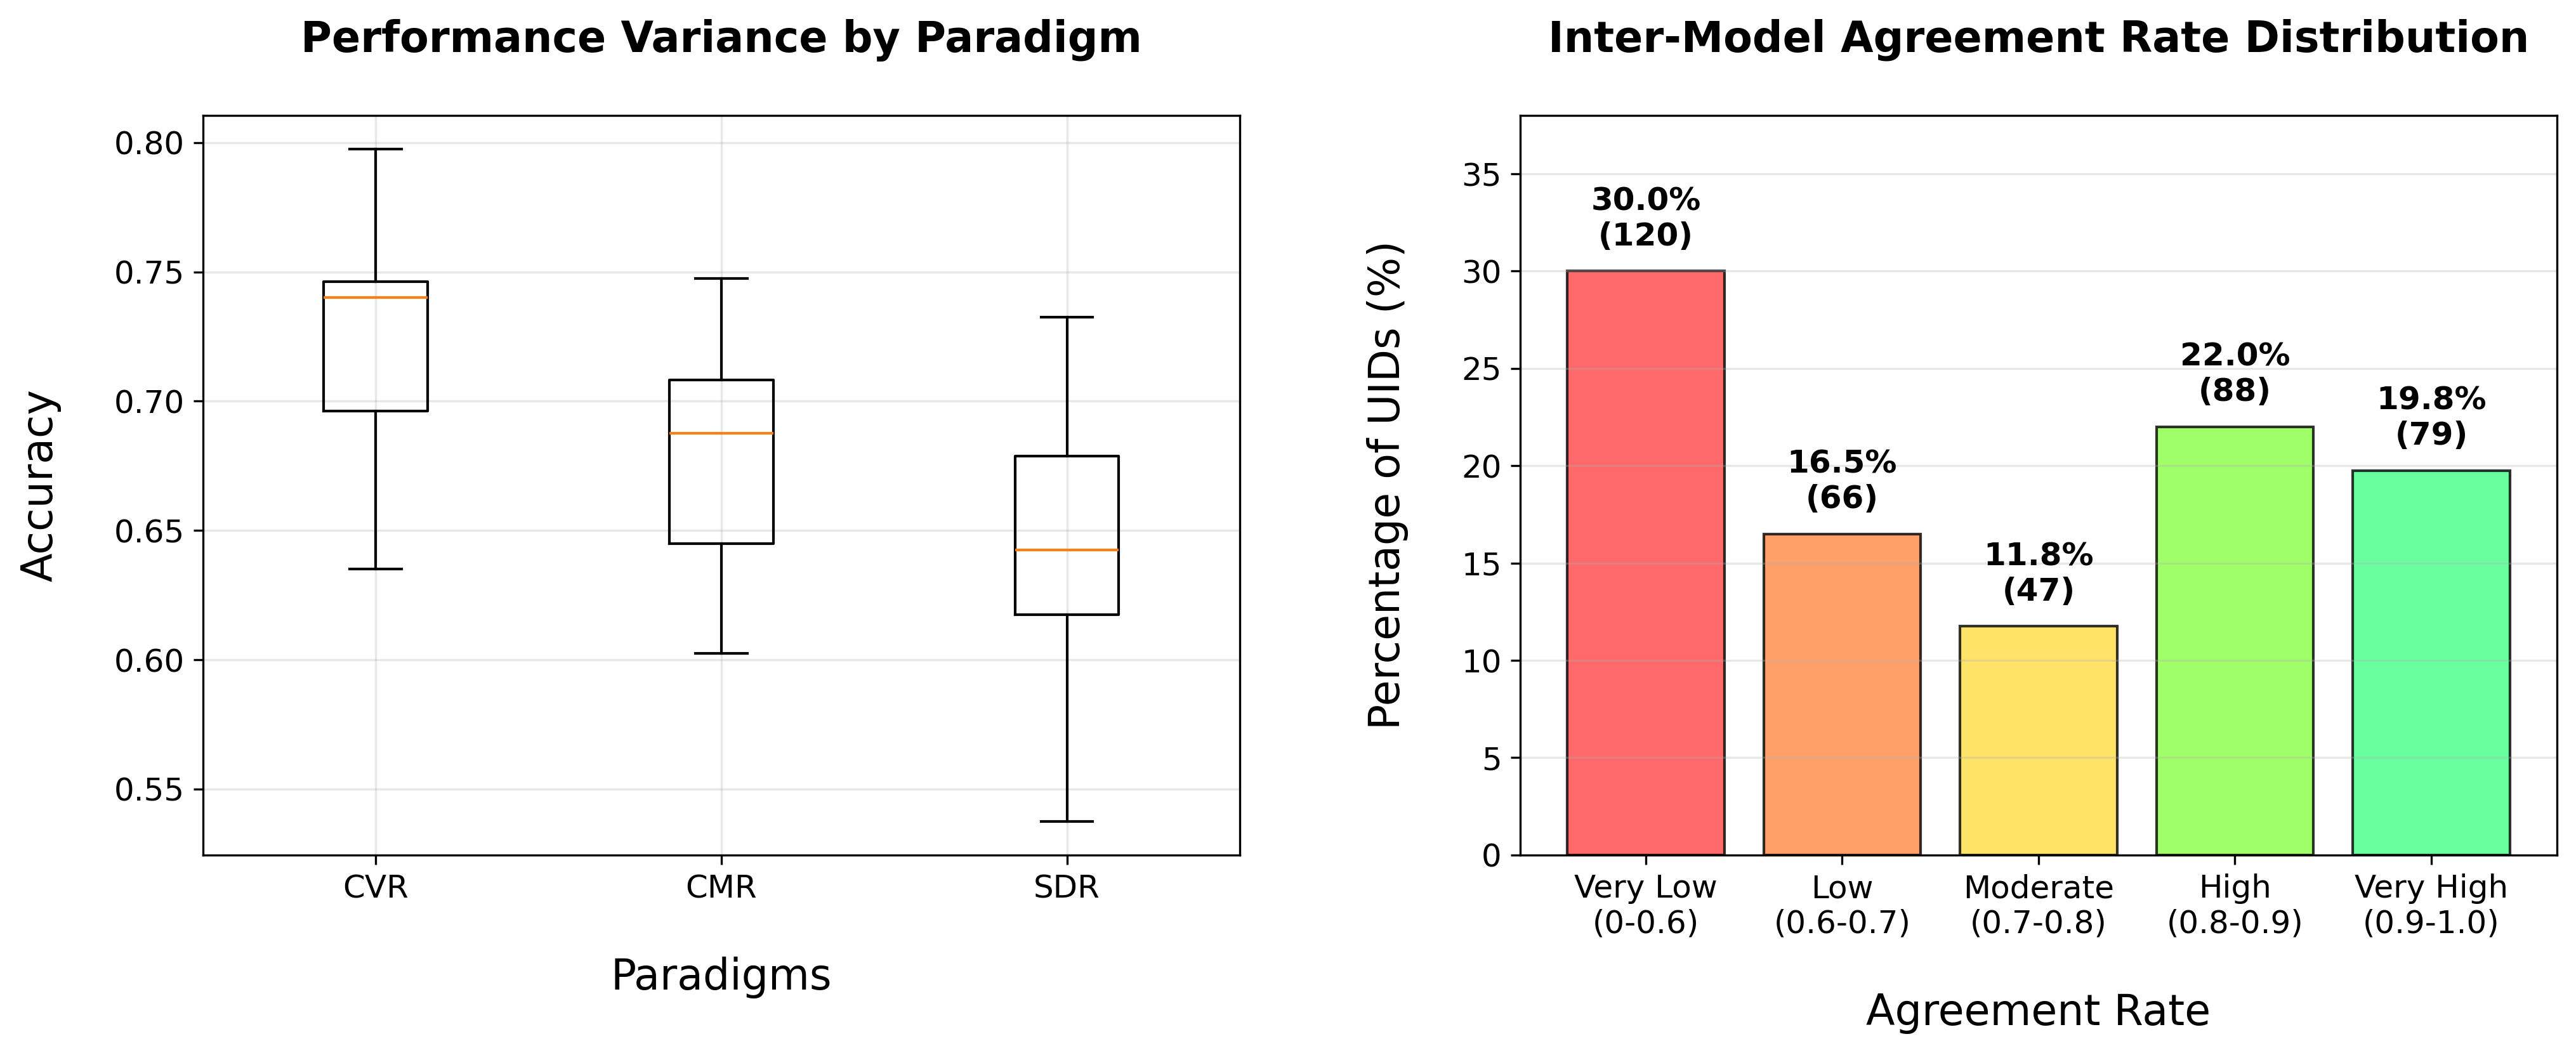


Agreement Rate Distribution Summary:
Total UIDs analyzed: 400
Very Low (0-0.6): 120 UIDs (30.0%)
Low (0.6-0.7): 66 UIDs (16.5%)
Moderate (0.7-0.8): 47 UIDs (11.8%)
High (0.8-0.9): 88 UIDs (22.0%)
Very High (0.9-1.0): 79 UIDs (19.8%)

Mean agreement rate: 0.736
Median agreement rate: 0.721
Standard deviation: 0.170


In [298]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Create figure with 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 1. Performance variance by paradigm (box plot)
paradigm_data = []
paradigm_labels = []
for paradigm, performances in paradigm_performances.items():
    if performances:
        paradigm_data.append(performances)
        paradigm_labels.append(paradigm)

ax1.boxplot(paradigm_data, tick_labels=paradigm_labels)
ax1.set_title('Performance Variance by Paradigm', fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Paradigms')
ax1.grid(True, alpha=0.3)

# 2. Calculate agreement rates for each UID
agreement_rates = []
uid_agreements = {}

for uid, model_results in uid_analysis.items():
    if model_results:  # Only process UIDs that have results
        # Count how many models agree with each other for this UID
        results_list = list(model_results.values())
        if len(results_list) > 1:
            # Calculate agreement rate as percentage of model pairs that agree
            total_pairs = 0
            agreeing_pairs = 0
            
            for i in range(len(results_list)):
                for j in range(i+1, len(results_list)):
                    total_pairs += 1
                    if results_list[i] == results_list[j]:
                        agreeing_pairs += 1
            
            if total_pairs > 0:
                agreement_rate = agreeing_pairs / total_pairs
                agreement_rates.append(agreement_rate)
                uid_agreements[uid] = agreement_rate

print(f"Calculated agreement rates for {len(agreement_rates)} UIDs")

# 3. Create agreement rate distribution
categories = ['Very Low\n(0-0.6)', 'Low\n(0.6-0.7)', 'Moderate\n(0.7-0.8)', 
              'High\n(0.8-0.9)', 'Very High\n(0.9-1.0)']
bounds = [0, 0.6, 0.7, 0.8, 0.9, 1.0]

# Count UIDs in each agreement category
counts = []
for i in range(len(bounds)-1):
    count = sum(1 for rate in agreement_rates if bounds[i] <= rate < bounds[i+1])
    counts.append(count)

# Handle the last category (0.9-1.0) to include 1.0
counts[-1] = sum(1 for rate in agreement_rates if rate >= 0.9)

# Convert to percentages
total_uids = len(agreement_rates)
percentages = [(count / total_uids) * 100 for count in counts] if total_uids > 0 else [0]*len(counts)

# Create bar chart
colors = ['#ff4444', '#ff8844', '#ffdd44', '#88ff44', '#44ff88']
bars = ax2.bar(categories, percentages, color=colors, alpha=0.8, edgecolor='black')
ax2.set_title('Inter-Model Agreement Rate Distribution', fontweight='bold')
ax2.set_xlabel('Agreement Rate')
ax2.set_ylabel('Percentage of UIDs (%)')

# Set y-axis limits with space for labels
max_percentage = max(percentages) if percentages else 0
ax2.set_ylim(0, max_percentage + 8)
ax2.grid(True, alpha=0.3, axis='y')

# Add percentage and count labels on bars
for bar, percentage, count in zip(bars, percentages, counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1, 
             f'{percentage:.1f}%\n({count})', 
             ha='center', va='bottom', fontweight='bold')

# Adjust x-axis labels
ax2.tick_params(axis='x')
plt.setp(ax2.get_xticklabels(), rotation=0, ha='center')
plt.tight_layout()
plt.tight_layout(pad=2.0, w_pad=4.0) 
plt.show()

# Print summary statistics
print(f"\nAgreement Rate Distribution Summary:")
print(f"Total UIDs analyzed: {total_uids}")
for i, (category, count, percentage) in enumerate(zip(categories, counts, percentages)):
    print(f"{category.replace(chr(10), ' ')}: {count} UIDs ({percentage:.1f}%)")

print(f"\nMean agreement rate: {np.mean(agreement_rates):.3f}")
print(f"Median agreement rate: {np.median(agreement_rates):.3f}")
print(f"Standard deviation: {np.std(agreement_rates):.3f}")

# Correlation Analysis (Consistency vs. Performance)

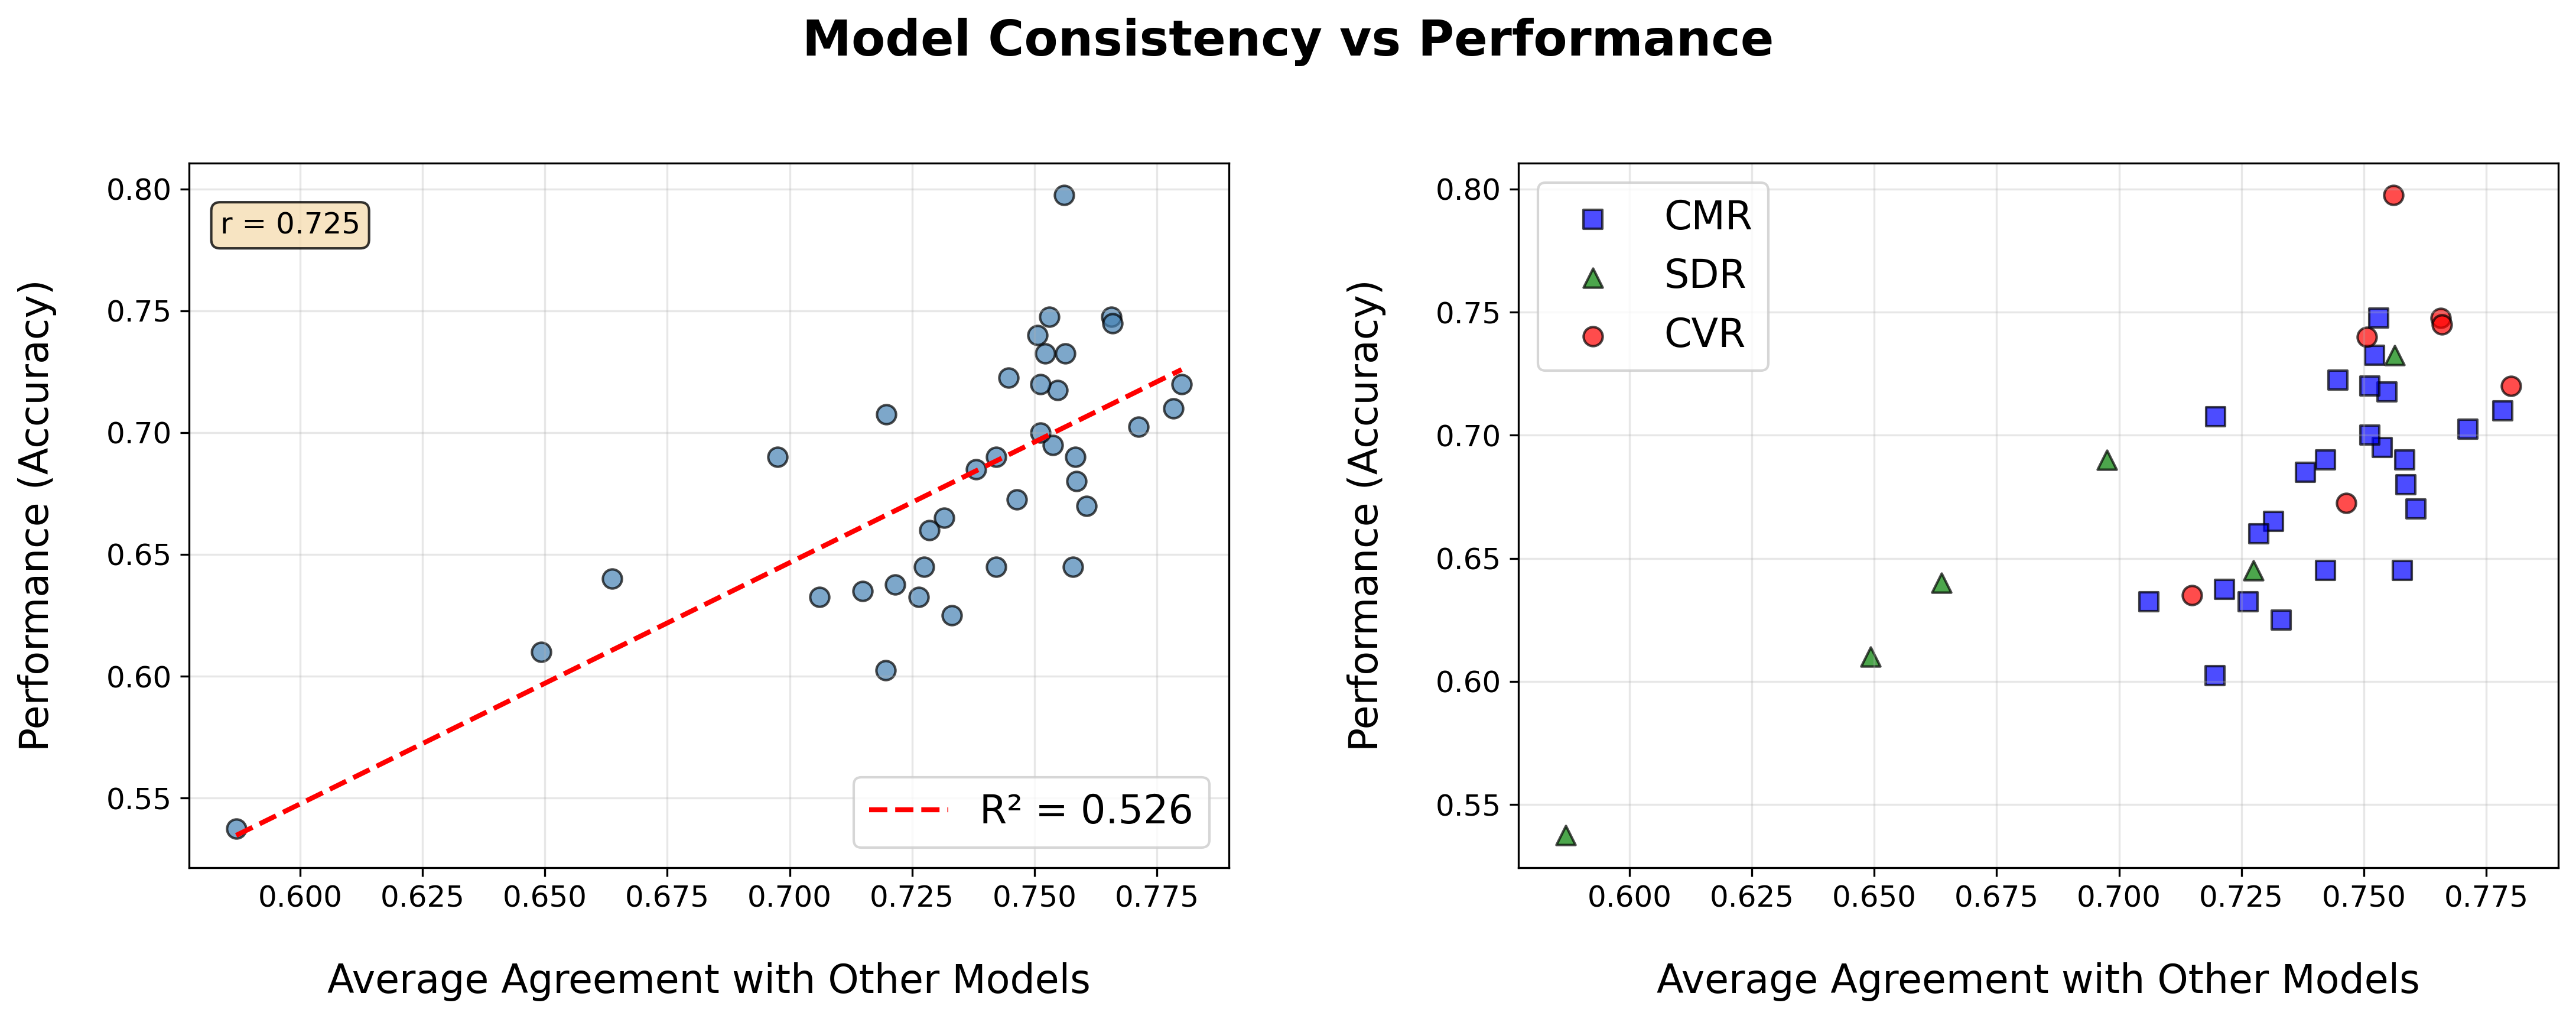


=== CORRELATION ANALYSIS SUMMARY ===
Pearson correlation coefficient: 0.725
R-squared (explained variance): 0.526
Linear relationship: Performance = -0.047 + (0.990) * Agreement


In [299]:
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 6))
fig2.suptitle('Model Consistency vs Performance', fontsize=20, fontweight='bold')
agreement_scores = [avg_agreement[model] for model in models]
performance_scores = [model_performance[model]['accuracy'] for model in models]
correlation = np.corrcoef(agreement_scores, performance_scores)[0, 1]

ax3.scatter(agreement_scores, performance_scores, alpha=0.7, s=60, color='steelblue', edgecolors='black')
X = np.array(agreement_scores).reshape(-1, 1)
y = np.array(performance_scores)
reg = LinearRegression().fit(X, y)
line_x = np.linspace(min(agreement_scores), max(agreement_scores), 100)
line_y = reg.predict(line_x.reshape(-1, 1))
ax3.plot(line_x, line_y, 'r--', linewidth=2, label=f'R² = {reg.score(X, y):.3f}')
ax3.set_xlabel('Average Agreement with Other Models')
ax3.set_ylabel('Performance (Accuracy)')
# ax3.set_title('Model Consistency vs Performance', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.text(0.03, 0.90, f'r = {correlation:.3f}', transform=ax3.transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
ax3.legend()

paradigm_colors = {'CVR': 'red', 'CMR': 'blue', 'SDR': 'green'}
paradigm_markers = {'CVR': 'o', 'CMR': 's', 'SDR': '^'}
plotted_labels = set()
for i, model in enumerate(models):
    paradigm = 'CVR' if model.startswith('cvr_') else ('CMR' if model.startswith('cmr_') else 'SDR')
    label = paradigm if paradigm not in plotted_labels else ""
    plotted_labels.add(paradigm)
    ax4.scatter(agreement_scores[i], performance_scores[i], color=paradigm_colors[paradigm], marker=paradigm_markers[paradigm], s=60, alpha=0.7, edgecolors='black', label=label)
ax4.set_xlabel('Average Agreement with Other Models')
ax4.set_ylabel('Performance (Accuracy)')
# ax4.set_title('Consistency vs Performance by Paradigm', fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()
plt.tight_layout(pad=2.0, w_pad=4.0) 
plt.show()

print("\n=== CORRELATION ANALYSIS SUMMARY ===")
print(f"Pearson correlation coefficient: {correlation:.3f}")
print(f"R-squared (explained variance): {reg.score(X, y):.3f}")
print(f"Linear relationship: Performance = {reg.intercept_:.3f} + ({reg.coef_[0]:.3f}) * Agreement")

# Export Enhanced Analysis

In [300]:
uid_agreements = {} # Placeholder

enhanced_results = {
    'model_performance': model_performance,
    'pos_neg_analysis': dict(pos_neg_analysis),
    'common_sense_performance': common_sense_performance,
    'common_sense_difficulty': common_sense_difficulty,
    'common_sense_mapping': common_sense_mapping,
    'metadata_sample': dict(list(metadata.items())[:5]),
    'correlation_analysis': {
        'pearson_correlation': correlation,
        'r_squared': reg.score(X, y),
        'regression_intercept': reg.intercept_,
        'regression_coefficient': reg.coef_[0]
    },
    'paradigm_statistics': paradigm_stats,
    'agreement_rates': agreement_rates,
    'uid_agreements': uid_agreements
}
with open('enhanced_analysis.json', 'w') as f:
    json.dump(enhanced_results, f, indent=2, default=str)
print("\nEnhanced analysis exported to enhanced_analysis.json")


Enhanced analysis exported to enhanced_analysis.json
